In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

Precompiling LuxZygoteExt
        Info Given LuxZygoteExt was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
  ? Lux → LuxZygoteExt
[ Info: Precompiling LuxZygoteExt [df13723f-0f22-5fb0-8a8f-885eac2ce1ee]
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
[ Info: Skipping precompilation since __precompile__(false). Importing LuxZygoteExt [df13723f-0f22-5fb0-8a8f-885eac2ce1ee].


In [3]:
using CUDA

In [4]:
using Statistics

In [5]:
n_x = 101
phases = range(-1.0, 1.0, n_x) |> collect;

In [6]:
import .PhasorNetworks: spike_current, phase_memory, neuron_constant

In [7]:
spk_args = SpikingArgs()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [8]:
repeats = 6
tspan = (0.0, repeats*1.0)

(0.0, 6.0)

In [9]:
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2]);

In [10]:
st = phase_to_train(phases, spk_args=spk_args, repeats = repeats)

Spike Train: (101,) with 606 spikes.

In [11]:
sol = phase_memory(st, tspan=tspan, spk_args=spk_args);

In [12]:
u = Array(sol);

In [13]:
u |> size

(101, 602)

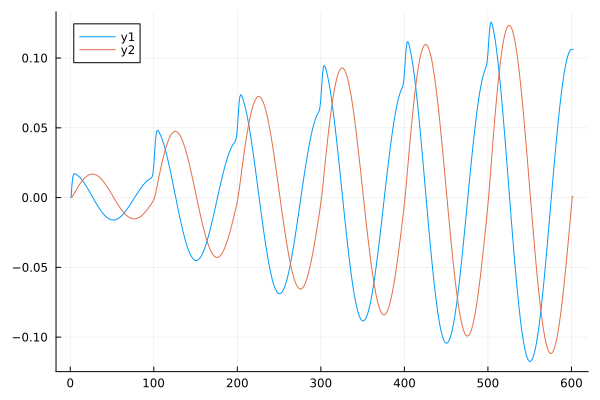

In [14]:
plot(real.(u[1,:]))
plot!(imag.(u[1,:]))

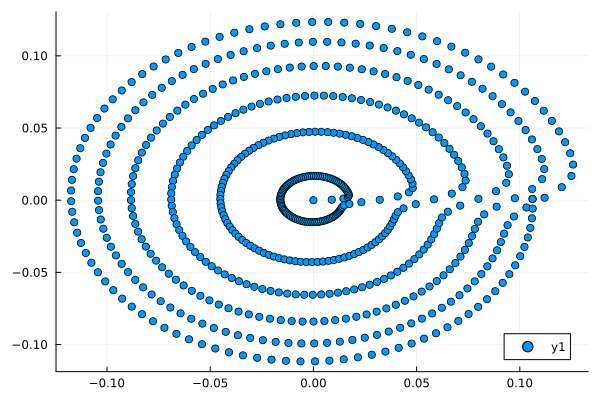

In [15]:
scatter(real.(u[1,:]), imag.(u[1,:]))

In [16]:
p = solution_to_phase(sol, spk_args=spk_args, final_t=false);

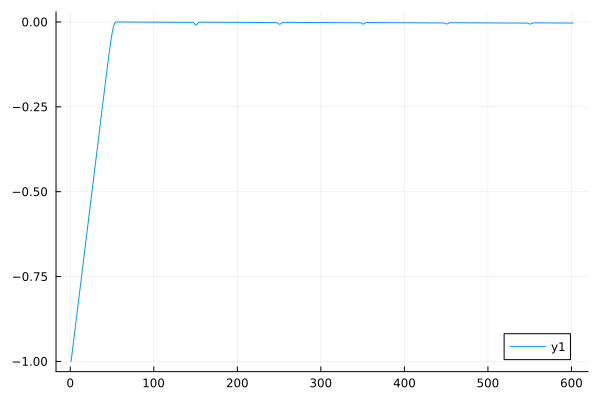

In [17]:
plot(p[51,:])

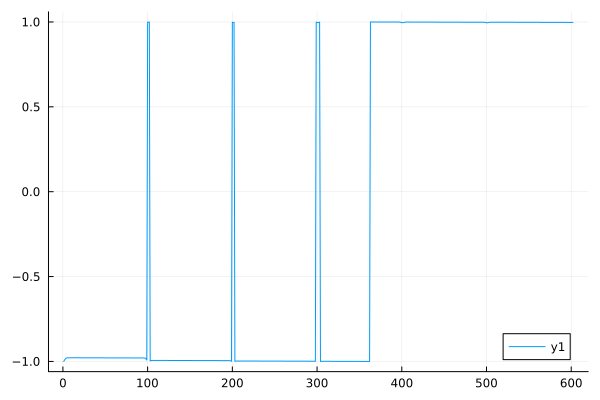

In [18]:
plot(p[1,:])

In [19]:
typeof(u)

Matrix{ComplexF32} (alias for Array{Complex{Float32}, 2})

In [20]:
st1 = solution_to_train(sol, tspan, spk_args = spk_args, offset=0.0)

Spike Train: (101,) with 606 spikes.

In [21]:
p1 = train_to_phase(st1, spk_args=spk_args)

6×101 Matrix{Float64}:
 0.997326  -0.982654  -0.962014  -0.941465  …  0.955291  0.968571  0.997326
 0.996732  -0.983247  -0.962607  -0.942058     0.956919  0.973878  0.996732
 0.996182  -0.983797  -0.963157  -0.942608     0.957058  0.974941  0.996182
 0.995674  -0.984305  -0.963665  -0.943116     0.95688   0.975171  0.995674
 0.995208  -0.984772  -0.964131  -0.943583     0.956602  0.975119  0.995208
 0.997503  -0.982832  -0.963308  -0.943606  …  0.956296  0.974951  0.997503

In [22]:
err2 = p1[end-1,:] .- phases;

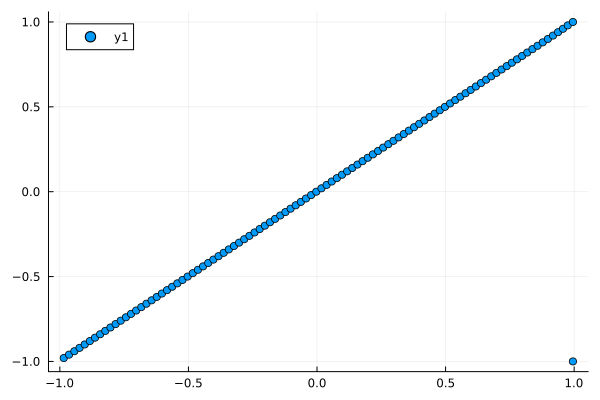

In [23]:
scatter(p1[end-1,:], phases)

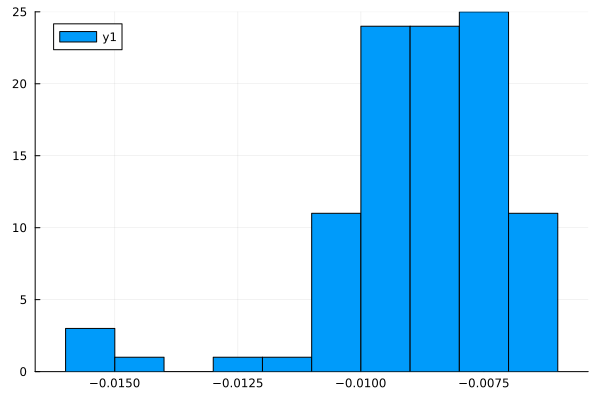

In [24]:
histogram(arc_error(err2))

In [25]:
stg = SpikeTrainGPU(st)

SpikeTrainGPU(CartesianIndex{1}[CartesianIndex(1,), CartesianIndex(2,), CartesianIndex(3,), CartesianIndex(4,), CartesianIndex(5,), CartesianIndex(6,), CartesianIndex(7,), CartesianIndex(8,), CartesianIndex(9,), CartesianIndex(10,)  …  CartesianIndex(92,), CartesianIndex(93,), CartesianIndex(94,), CartesianIndex(95,), CartesianIndex(96,), CartesianIndex(97,), CartesianIndex(98,), CartesianIndex(99,), CartesianIndex(100,), CartesianIndex(101,)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  597, 598, 599, 600, 601, 602, 603, 604, 605, 606], Float32[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  5.91, 5.92, 5.93, 5.94, 5.95, 5.96, 5.97, 5.98, 5.99, 5.0], (101,), 101, 0.0)

In [26]:
using ChainRulesCore: ignore_derivatives

In [27]:
import .PhasorNetworks: gaussian_kernel

In [28]:
stg.indices

606-element CuArray{CartesianIndex{1}, 1, CUDA.DeviceMemory}:
 CartesianIndex(1,)
 CartesianIndex(2,)
 CartesianIndex(3,)
 CartesianIndex(4,)
 CartesianIndex(5,)
 CartesianIndex(6,)
 CartesianIndex(7,)
 CartesianIndex(8,)
 CartesianIndex(9,)
 CartesianIndex(10,)
 CartesianIndex(11,)
 CartesianIndex(12,)
 CartesianIndex(13,)
 ⋮
 CartesianIndex(90,)
 CartesianIndex(91,)
 CartesianIndex(92,)
 CartesianIndex(93,)
 CartesianIndex(94,)
 CartesianIndex(95,)
 CartesianIndex(96,)
 CartesianIndex(97,)
 CartesianIndex(98,)
 CartesianIndex(99,)
 CartesianIndex(100,)
 CartesianIndex(101,)

In [29]:
stg.linear_indices

606-element CuArray{Int64, 1, CUDA.DeviceMemory}:
   1
   2
   3
   4
   5
   6
   7
   8
   9
  10
  11
  12
  13
   ⋮
 595
 596
 597
 598
 599
 600
 601
 602
 603
 604
 605
 606

In [30]:
stg.shape

(101,)

In [31]:
stg.linear_shape

101

In [32]:
function scatter_add_kernel!(output, values, indices)
    i = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    if i <= length(indices)
        index = indices[i]
        value = values[i]
        CUDA.@atomic output[index] += value
    end
    return nothing
end

function parallel_scatter_add(indices::CuArray{Int}, values::CuArray{T}, output_size::Int) where T
    @assert length(indices) == length(values) "Length of indices and values must match"
    
    output = CUDA.zeros(T, output_size)
    threads = 256
    blocks = cld(length(indices), threads)
    
    @cuda threads=threads blocks=blocks scatter_add_kernel!(output, values, indices)
    
    return output
end

parallel_scatter_add (generic function with 1 method)

In [33]:
# Set up sample data
n = 1_00
m = 100_000

# Create indices and values on the GPU
d_indices = rand(1:n, m) |> CuArray{Int}
d_values = CUDA.rand(Float32, m);

In [34]:
typeof(m)

Int64

In [35]:
d_indices

100000-element CuArray{Int64, 1, CUDA.DeviceMemory}:
 73
 16
 38
  1
 63
 86
 39
  9
 45
 83
 10
 16
 67
  ⋮
 77
 37
 80
 29
 71
 24
 18
 44
 53
 87
  1
  7

In [36]:
v = parallel_scatter_add(d_indices, d_values, n)

100-element CuArray{Float32, 1, CUDA.DeviceMemory}:
 494.2579
 505.24036
 494.35428
 522.2352
 495.477
 503.54843
 495.23447
 498.4822
 480.24216
 511.74066
 508.3993
 503.40167
 510.21375
   ⋮
 521.97327
 515.81134
 498.07123
 501.4272
 476.66022
 484.2274
 533.5759
 520.3288
 506.4494
 504.91458
 508.8008
 494.2959

In [37]:
for i in 1:1000 parallel_scatter_add(d_indices, d_values, n) end

In [38]:
for i in 1:10000 parallel_scatter_add(d_indices, d_values, n) end

In [ ]:
#for i in 1:100000 parallel_scatter_add(d_indices, d_values, n) end

In [40]:
v

100-element CuArray{Float32, 1, CUDA.DeviceMemory}:
 494.2579
 505.24036
 494.35428
 522.2352
 495.477
 503.54843
 495.23447
 498.4822
 480.24216
 511.74066
 508.3993
 503.40167
 510.21375
   ⋮
 521.97327
 515.81134
 498.07123
 501.4272
 476.66022
 484.2274
 533.5759
 520.3288
 506.4494
 504.91458
 508.8008
 494.2959

In [41]:
function gaussian_kernel_gpu(x::Float32, t::Float32, t_sigma::Float32)
    i = exp(-1.0f0 * ((t - x) / (2.0f0 * t_sigma))^2.0f0)
    return i
end

gaussian_kernel_gpu (generic function with 1 method)

In [42]:
typeof(spk_args.t_window)

Float32

In [43]:
i0 = gaussian_kernel_gpu.(stg.times, 0.4f0, Float32(spk_args.t_window))

606-element CuArray{Float32, 1, CUDA.DeviceMemory}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [44]:
for i in 1:1000 gaussian_kernel_gpu.(stg.times, 0.4f0, Float32(spk_args.t_window)) end

In [45]:
for i in 1:10000 gaussian_kernel_gpu.(stg.times, 0.4f0, Float32(spk_args.t_window)) end

In [ ]:
#for i in 1:100000 gaussian_kernel_gpu.(stg.times, 0.4f0, Float32(spk_args.t_window)) end

In [47]:
i0

606-element CuArray{Float32, 1, CUDA.DeviceMemory}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [48]:
stg.linear_indices

606-element CuArray{Int64, 1, CUDA.DeviceMemory}:
   1
   2
   3
   4
   5
   6
   7
   8
   9
  10
  11
  12
  13
   ⋮
 595
 596
 597
 598
 599
 600
 601
 602
 603
 604
 605
 606

In [49]:
stg.linear_indices

606-element CuArray{Int64, 1, CUDA.DeviceMemory}:
   1
   2
   3
   4
   5
   6
   7
   8
   9
  10
  11
  12
  13
   ⋮
 595
 596
 597
 598
 599
 600
 601
 602
 603
 604
 605
 606

In [50]:
typeof(stg.linear_shape)

Int64

In [51]:
function parallel_current(stg::SpikeTrainGPU, t::Float32, spk_args::SpikingArgs)
    currents = gaussian_kernel_gpu.(stg.times, t, Float32(spk_args.t_window))
    output = parallel_scatter_add(stg.linear_indices, currents, stg.linear_shape)
    
    return output
    
end

parallel_current (generic function with 1 method)

In [52]:
ik = parallel_current(stg, 0.1f0, spk_args)

101-element CuArray{Float32, 1, CUDA.DeviceMemory}:
 1.3887945f-11
 1.6052218f-9
 1.12535176f-7
 4.7851177f-6
 0.00012340969
 0.0019304542
 0.01831562
 0.1053992
 0.36787927
 0.77880085
 1.0
 0.77880085
 0.3678796
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.3887945f-11

In [53]:
for i in 1:1000
    parallel_current(stg, 0.1f0, spk_args)
end

In [54]:
for i in 1:10000
    parallel_current(stg, 0.1f0, spk_args)
end

In [55]:
0.0f0:0.01f0:1.1f0

0.0f0:0.01f0:1.1f0

In [56]:
iv = stack([parallel_current(stg, t, spk_args) for t in 0.0f0:0.01f0:1.1f0])

101×111 CuArray{Float32, 2, CUDA.DeviceMemory}:
 1.0          0.778801     0.367879     …  0.0          0.0
 0.778801     1.0          0.778801        0.0          0.0
 0.367879     0.778801     1.0             0.0          0.0
 0.105399     0.367879     0.778801        0.0          0.0
 0.0183156    0.105399     0.367879        0.0          0.0
 0.00193045   0.0183156    0.105399     …  0.0          0.0
 0.00012341   0.00193045   0.0183156       0.0          0.0
 4.78512f-6   0.00012341   0.00193045      0.0          0.0
 1.12535f-7   4.78512f-6   0.00012341      0.0          0.0
 1.60522f-9   1.12535f-7   4.7851f-6       0.0          0.0
 1.38879f-11  1.60522f-9   1.12535f-7   …  0.0          0.0
 7.28772f-14  1.38879f-11  1.60522f-9      0.0          0.0
 2.31952f-16  7.28772f-14  1.38879f-11     0.0          0.0
 ⋮                                      ⋱               ⋮
 0.0          0.0          0.0             0.0          0.0
 0.0          0.0          0.0          …  0.0        

In [57]:
iv2 = Array(iv)

101×111 Matrix{Float32}:
 1.0          0.778801     0.367879     …  0.0          0.0
 0.778801     1.0          0.778801        0.0          0.0
 0.367879     0.778801     1.0             0.0          0.0
 0.105399     0.367879     0.778801        0.0          0.0
 0.0183156    0.105399     0.367879        0.0          0.0
 0.00193045   0.0183156    0.105399     …  0.0          0.0
 0.00012341   0.00193045   0.0183156       0.0          0.0
 4.78512f-6   0.00012341   0.00193045      0.0          0.0
 1.12535f-7   4.78512f-6   0.00012341      0.0          0.0
 1.60522f-9   1.12535f-7   4.7851f-6       0.0          0.0
 1.38879f-11  1.60522f-9   1.12535f-7   …  0.0          0.0
 7.28772f-14  1.38879f-11  1.60522f-9      0.0          0.0
 2.31952f-16  7.28772f-14  1.38879f-11     0.0          0.0
 ⋮                                      ⋱               ⋮
 0.0          0.0          0.0             0.0          0.0
 0.0          0.0          0.0          …  0.0          0.0
 0.0          0.0

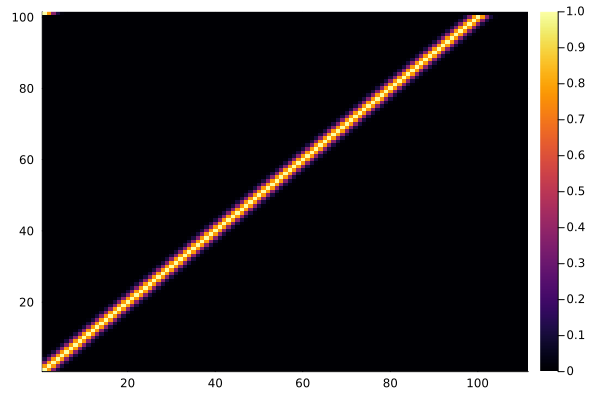

In [58]:
heatmap(iv2)

In [59]:
function spike_current(train::SpikeTrainGPU, t::Float32, spk_args::SpikingArgs)
    scale = spk_args.spk_scale

    current = parallel_current(train, t, spk_args)
    current = reshape(current, train.shape)
    
    return current
end


spike_current (generic function with 3 methods)

In [60]:
ival = spike_current(stg, 0.4f0, spk_args)

101-element CuArray{Float32, 1, CUDA.DeviceMemory}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

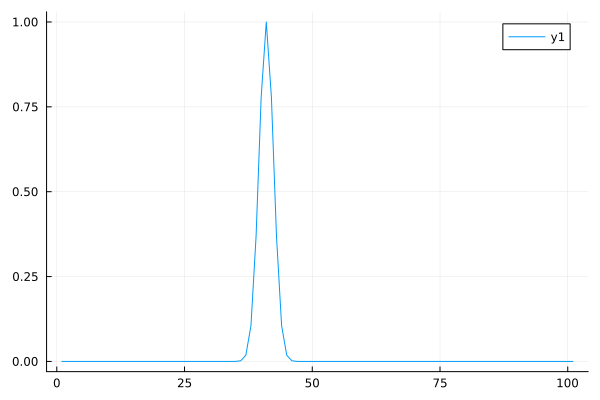

In [61]:
plot(Array(ival))

In [62]:
@time ivals = stack([Array(spike_current(stg, t, spk_args)) for t in 0.0f0:0.001f0:1.0f0], dims=1)

  0.176658 seconds (374.12 k allocations: 21.590 MiB, 77.85% compilation time)


1001×101 Matrix{Float32}:
 1.0       0.778801  0.367879  0.105399  …  0.0       0.0       1.0
 0.997503  0.816687  0.405555  0.122151     0.0       0.0       0.997503
 0.99005   0.852144  0.444858  0.140858     0.0       0.0       0.99005
 0.977751  0.884706  0.485537  0.161621     0.0       0.0       0.977751
 0.96079   0.913931  0.527292  0.18452      0.0       0.0       0.96079
 0.939413  0.939413  0.569783  0.209611  …  0.0       0.0       0.939413
 0.913931  0.96079   0.612626  0.236928     0.0       0.0       0.913931
 0.884706  0.977751  0.655406  0.266468     0.0       0.0       0.884706
 0.852144  0.99005   0.697676  0.298197     0.0       0.0       0.852144
 0.816687  0.997503  0.738968  0.33204      0.0       0.0       0.816687
 0.778801  1.0       0.778801  0.367879  …  0.0       0.0       0.778801
 0.738968  0.997503  0.816687  0.405555     0.0       0.0       0.738968
 0.697676  0.99005   0.852144  0.444858     0.0       0.0       0.697676
 ⋮                              

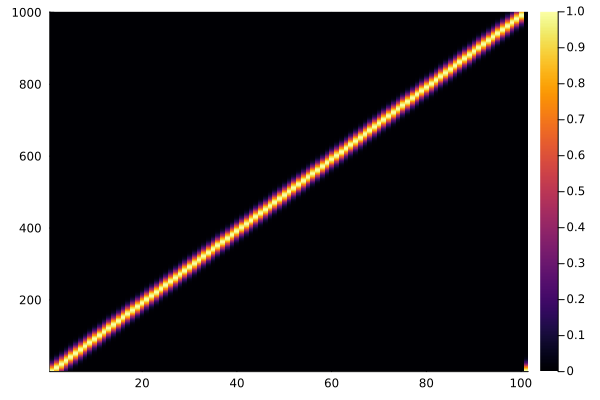

In [63]:
heatmap(ivals)

In [64]:
@time ivals2 = stack([Array(spike_current(st, t, spk_args)) for t in 0.0:0.001:1.0], dims=1)

  0.127838 seconds (222.14 k allocations: 19.759 MiB, 35.83% gc time, 59.63% compilation time)


1001×101 Matrix{Float32}:
 1.0       0.778801  0.367879   0.105399   …  0.0       0.0       1.0
 0.997503  0.816686  0.405555   0.122151      0.0       0.0       0.997503
 0.99005   0.852144  0.444858   0.140858      0.0       0.0       0.99005
 0.977751  0.884706  0.485537   0.161621      0.0       0.0       0.977751
 0.960789  0.913931  0.527292   0.18452       0.0       0.0       0.960789
 0.939413  0.939413  0.569783   0.209611   …  0.0       0.0       0.939413
 0.913931  0.960789  0.612626   0.236928      0.0       0.0       0.913931
 0.884706  0.977751  0.655406   0.266468      0.0       0.0       0.884706
 0.852144  0.99005   0.697676   0.298197      0.0       0.0       0.852144
 0.816686  0.997503  0.738968   0.33204       0.0       0.0       0.816686
 0.778801  1.0       0.778801   0.367879   …  0.0       0.0       0.778801
 0.738968  0.997503  0.816686   0.405555      0.0       0.0       0.738968
 0.697676  0.99005   0.852144   0.444858      0.0       0.0       0.697676
 ⋮   

In [65]:
sum(abs2.(ivals .- ivals2))

31.03234f0

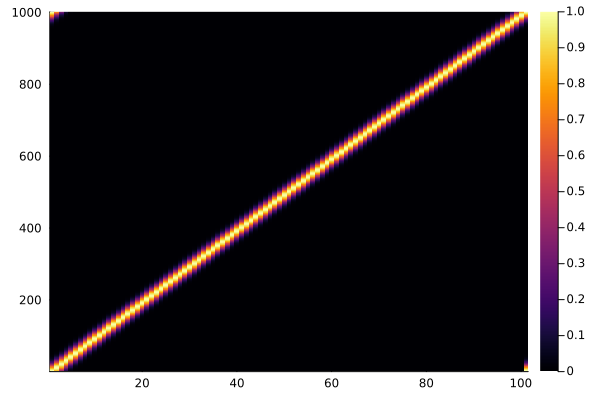

In [66]:
heatmap(ivals2)

In [67]:
spk_args

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [68]:
z0 = rand(ComplexF32, (101,)) |> CuArray

101-element CuArray{ComplexF32, 1, CUDA.DeviceMemory}:
   0.9922836f0 + 0.6867567f0im
 0.052119672f0 + 0.8668858f0im
   0.4105847f0 + 0.6631419f0im
   0.9560331f0 + 0.51794636f0im
  0.52062076f0 + 0.52863246f0im
  0.11470455f0 + 0.4998036f0im
   0.9638545f0 + 0.9079713f0im
  0.89240974f0 + 0.5274431f0im
   0.9125681f0 + 0.5154261f0im
  0.19150001f0 + 0.044708014f0im
 0.007762909f0 + 0.8389342f0im
  0.66040045f0 + 0.15483129f0im
  0.10886687f0 + 0.5133484f0im
               ⋮
   0.7000479f0 + 0.31533396f0im
  0.88680017f0 + 0.59990007f0im
  0.47846574f0 + 0.8129176f0im
   0.9100779f0 + 0.83406776f0im
  0.93646806f0 + 0.52116156f0im
   0.3209067f0 + 0.6523561f0im
  0.55574584f0 + 0.47386342f0im
  0.39279622f0 + 0.96138364f0im
   0.4367575f0 + 0.9378744f0im
  0.48403257f0 + 0.6823913f0im
  0.60560673f0 + 0.042830408f0im
  0.23009712f0 + 0.6801055f0im

In [69]:
spk_args.update_fn(z0)

101-element CuArray{ComplexF64, 1, CUDA.DeviceMemory}:
   -4.513476141030842 + 6.097350291155157im
   -5.457227938607597 + 0.1541004003593687im
   -4.248760420857935 + 2.447151296938637im
  -3.4455595997112685 + 5.903343919773244im
  -3.4256198725036353 + 3.165430236610416im
   -3.163299563135934 + 0.6207492168789077im
   -5.897722974316199 + 5.874482113362226im
  -3.4925047560844384 + 5.501687154394507im
  -3.4210313152499654 + 5.630749208234327im
  -0.3192087359454057 + 1.1942884344176972im
   -5.272731514885108 - 0.11901104375956296im
  -1.1049137799734705 + 4.118452147227243im
  -3.2472365024739527 + 0.5813610389081163im
                      ⋮
    -2.12131130378981 + 4.335463950347185im
  -3.9466433224559396 + 5.451949783042941im
   -5.203405006932034 + 2.8437053614222334im
   -5.422617895361528 + 5.55137472013717im
   -3.461848248606391 + 5.779770072498074im
    -4.16305552888242 + 1.8858450346945417im
   -3.088520865861385 + 3.3970814108841862im
   -6.119110811074322 + 2.2757346

In [70]:
function dzdt(u, p, t)
    return spk_args.update_fn(u) .+ spike_current(stg, t, spk_args)
end

dzdt (generic function with 1 method)

In [71]:
du0 = dzdt(z0, nothing, 0.1f0)

101-element CuArray{ComplexF64, 1, CUDA.DeviceMemory}:
   -4.513476141016954 + 6.097350291155157im
   -5.457227937002375 + 0.1541004003593687im
   -4.248760308322759 + 2.447151296938637im
  -3.4455548145936152 + 5.903343919773244im
  -3.4254964628183058 + 3.165430236610416im
   -3.161369108972122 + 0.6207492168789077im
   -5.879407353595813 + 5.874482113362226im
  -3.3871055572543107 + 5.501687154394507im
   -3.053152043742702 + 5.630749208234327im
   0.4595921092007735 + 1.1942884344176972im
   -4.272731514885108 - 0.11901104375956296im
  -0.3261129348272913 + 4.118452147227243im
  -2.8793569031411432 + 0.5813610389081163im
                      ⋮
    -2.12131130378981 + 4.335463950347185im
  -3.9466433224559396 + 5.451949783042941im
   -5.203405006932034 + 2.8437053614222334im
   -5.422617895361528 + 5.55137472013717im
   -3.461848248606391 + 5.779770072498074im
    -4.16305552888242 + 1.8858450346945417im
   -3.088520865861385 + 3.3970814108841862im
   -6.119110811074322 + 2.2757346

In [72]:
du = CUDA.zeros(ComplexF32, (101,)) |> CuArray

101-element CuArray{ComplexF32, 1, CUDA.DeviceMemory}:
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
       ⋮
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im

In [73]:
function dzdt!(du, u, p, t)
    sum!(du, spk_args.update_fn(u) .+ spike_current(stg, t, spk_args))
    return nothing
end

dzdt! (generic function with 1 method)

In [74]:
#dzdt!(du, z0, nothing, 0.1f0)

In [75]:
#sum(abs2.(du .- du0))

In [76]:
function phase_memory(x::SpikeTrainGPU; tspan::Tuple{<:Real, <:Real} = (0.0, 10.0), spk_args::SpikingArgs)
    update_fn = spk_args.update_fn

    #set up compartments for each sample
    u0 = CUDA.zeros(ComplexF32, x.shape)
    #resonate in time with the input spikes
    function dzdt(u, p, t)
        return spk_args.update_fn(u) .+ spike_current(stg, t, spk_args)
    end
    
    prob = ODEProblem(dzdt, u0, tspan)
    return prob
    #sol = solve(prob, spk_args.solver; spk_args.solver_args...)

    return sol
end

phase_memory (generic function with 4 methods)

In [77]:
p0 = phase_memory(stg, spk_args=spk_args)

ODEProblem with uType CuArray{ComplexF32, 1, CUDA.DeviceMemory} and tType Float64. In-place: false
timespan: (0.0, 10.0)
u0: 101-element CuArray{ComplexF32, 1, CUDA.DeviceMemory}:
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
       ⋮
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im

In [78]:
sol0 = solve(p0, Tsit5(); spk_args.solver_args...)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 1002-element Vector{Float64}:
  0.0
  0.009999999776482582
  0.019999999552965164
  0.029999999329447746
  0.03999999910593033
  0.04999999888241291
  0.05999999865889549
  0.06999999843537807
  0.07999999821186066
  0.08999999798834324
  0.09999999776482582
  0.1099999975413084
  0.11999999731779099
  ⋮
  9.899999778717756
  9.909999778494239
  9.919999778270721
  9.929999778047204
  9.939999777823687
  9.94999977760017
  9.959999777376652
  9.969999777153134
  9.979999776929617
  9.9899997767061
  9.999999776482582
 10.0
u: 1002-element Vector{CuArray{ComplexF32, 1, CUDA.DeviceMemory}}:
 ComplexF32[0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im  …  0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0

In [79]:
u2 = Array(sol0) |> Array

101×1002 Matrix{ComplexF32}:
 0.0+0.0im   0.00920961+0.000301193im  …  0.00239469-0.000170223im
 0.0+0.0im   0.00921108+0.000277517im     0.00363301-0.000361763im
 0.0+0.0im   0.00570279+0.000157308im     0.00438349-0.000617621im
 0.0+0.0im   0.00218453+5.4901f-5im       0.00464086-0.000904597im
 0.0+0.0im  0.000517274+1.18033f-5im      0.00465417-0.00119941im
 0.0+0.0im   7.56199f-5+1.56341f-6im   …  0.00458907-0.0014927im
 0.0+0.0im   6.81547f-6+1.27526f-7im      0.00449619-0.0017815im
 0.0+0.0im   3.78167f-7+6.39911f-9im      0.00438427-0.00206443im
 0.0+0.0im   1.29013f-8+1.97189f-10im     0.00425449-0.00234032im
 0.0+0.0im  2.70312f-10+3.72259f-12im     0.00410735-0.00260806im
 0.0+0.0im  3.47544f-12+4.29229f-14im  …  0.00394337-0.00286654im
 0.0+0.0im  2.74032f-14+3.01169f-16im     0.00376311-0.00311471im
 0.0+0.0im  1.32458f-16+1.28021f-18im     0.00356723-0.00335155im
    ⋮                                  ⋱  
 0.0+0.0im          0.0+0.0im             0.00440026+0.00363834im
 0

In [80]:
usol0 = solution_to_potential(sol0)

101×1002 CuArray{ComplexF32, 2, CUDA.DeviceMemory}:
 0.0+0.0im   0.00920961+0.000301193im  …  0.00239469-0.000170223im
 0.0+0.0im   0.00921108+0.000277517im     0.00363301-0.000361763im
 0.0+0.0im   0.00570279+0.000157308im     0.00438349-0.000617621im
 0.0+0.0im   0.00218453+5.4901f-5im       0.00464086-0.000904597im
 0.0+0.0im  0.000517274+1.18033f-5im      0.00465417-0.00119941im
 0.0+0.0im   7.56199f-5+1.56341f-6im   …  0.00458907-0.0014927im
 0.0+0.0im   6.81547f-6+1.27526f-7im      0.00449619-0.0017815im
 0.0+0.0im   3.78167f-7+6.39911f-9im      0.00438427-0.00206443im
 0.0+0.0im   1.29013f-8+1.97189f-10im     0.00425449-0.00234032im
 0.0+0.0im  2.70312f-10+3.72259f-12im     0.00410735-0.00260806im
 0.0+0.0im  3.47544f-12+4.29229f-14im  …  0.00394337-0.00286654im
 0.0+0.0im  2.74032f-14+3.01169f-16im     0.00376311-0.00311471im
 0.0+0.0im  1.32458f-16+1.28021f-18im     0.00356723-0.00335155im
    ⋮                                  ⋱  
 0.0+0.0im          0.0+0.0im             0.0

In [81]:
sol0.t

1002-element Vector{Float64}:
  0.0
  0.009999999776482582
  0.019999999552965164
  0.029999999329447746
  0.03999999910593033
  0.04999999888241291
  0.05999999865889549
  0.06999999843537807
  0.07999999821186066
  0.08999999798834324
  0.09999999776482582
  0.1099999975413084
  0.11999999731779099
  ⋮
  9.899999778717756
  9.909999778494239
  9.919999778270721
  9.929999778047204
  9.939999777823687
  9.94999977760017
  9.959999777376652
  9.969999777153134
  9.979999776929617
  9.9899997767061
  9.999999776482582
 10.0

In [82]:
import .PhasorNetworks: potential_to_phase, phase_to_potential

In [83]:
function phase_to_potential(phase::Real, ts::AbstractVector; offset::Real=0.0, spk_args::SpikingArgs)
    return [phase_to_potential(phase, t, offset=offset, spk_args=spk_args) for t in ts]
end

function phase_to_potential(phase::AbstractArray, ts::AbstractVector; offset::Real=0.0, spk_args::SpikingArgs)
    return [phase_to_potential(p, t, offset=offset, spk_args=spk_args) for p in phase, t in ts]
end

function phase_to_potential(phase::Real, t::Real; offset::Real=0.0, spk_args::SpikingArgs)
    period = Float32(spk_args.t_period)
    k = ComplexF32(1im * imag(neuron_constant(spk_args)))
    potential = ComplexF32(exp.(k .* ((t .- offset) .- (phase - 1.0f0)/2.0f0 * period)))
    return potential
end

phase_to_potential (generic function with 3 methods)

In [84]:
function potential_to_phase(potential::CuArray, ts::AbstractVector; spk_args::SpikingArgs, offset::Real=0.0, threshold::Bool=false)
    @assert size(potential)[end] == length(ts) "Time dimensions must match"
    dims = collect(1:ndims(potential))

    #find the angle of a neuron representing 0 phase at the current moment in time
    current_zeros = cu(phase_to_potential.(0.0f0, ts, offset=offset, spk_args=spk_args))

    #get the arc subtended in the complex plane between that reference and our neuron potentials
    potential = permutedims(potential, reverse(dims))
    arc = angle.(current_zeros) .- angle.(potential)
    
    #normalize by pi and shift to -1, 1
    phase = mod.((arc ./ pi .+ 1.0), 2.0) .- 1.0

    #replace silent neurons with NaN
    silent = abs.(potential) .< spk_args.threshold
    phase[silent] .= NaN
    phase = permutedims(phase, reverse(dims))
    
    return phase
end

potential_to_phase (generic function with 3 methods)

In [85]:
c = potential_to_phase(usol0, sol0.t, spk_args=spk_args)

101×1002 CuArray{Float64, 2, CUDA.DeviceMemory}:
 NaN   -0.990406   -0.983061   -0.979084  …  -0.977411  -0.977411  -0.977411
 NaN   -0.989587   -0.979988   -0.973173     -0.968407  -0.968407  -0.968407
 NaN   -0.988778   -0.976915   -0.966776     -0.955444  -0.955444  -0.955444
 NaN   -0.987998   -0.974092   -0.960873     -0.938723  -0.938723  -0.938723
 NaN  NaN          -0.971679   -0.956125     -0.919715  -0.919715  -0.919715
 NaN  NaN         NaN          -0.952624  …  -0.899898  -0.899898  -0.899898
 NaN  NaN         NaN         NaN            -0.879918  -0.879918  -0.879918
 NaN  NaN         NaN         NaN            -0.859919  -0.859919  -0.859919
 NaN  NaN         NaN         NaN            -0.839919  -0.839919  -0.839919
 NaN  NaN         NaN         NaN            -0.819919  -0.819919  -0.819919
 NaN  NaN         NaN         NaN         …  -0.799919  -0.799919  -0.799919
 NaN  NaN         NaN         NaN            -0.779919  -0.779919  -0.779919
 NaN  NaN         NaN      

In [86]:
c |> size

(101, 1002)

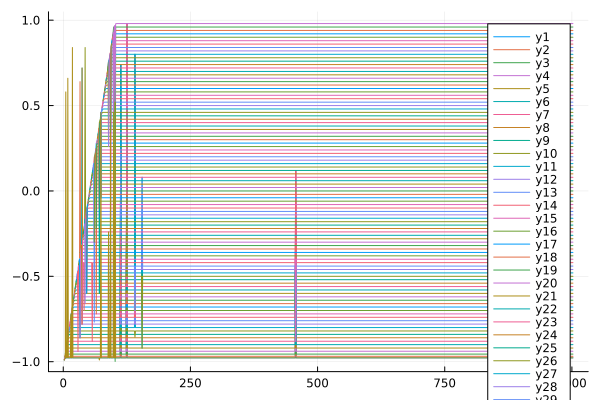

In [87]:
plot(Array(c'))

In [93]:
function phase_memory(x::SpikeTrainGPU; tspan::Tuple{<:Real, <:Real} = (0.0, 10.0), spk_args::SpikingArgs)
    update_fn = spk_args.update_fn

    #set up compartments for each sample
    u0 = CUDA.zeros(ComplexF32, x.shape)
    
    #resonate in time with the input spikes
    function dzdt!(du, u, p, t)
        du .= spk_args.update_fn(u) .+ spike_current(stg, t, spk_args)
        return nothing
    end
    
    prob = ODEProblem(dzdt!, u0, tspan)
    return prob
    #sol = solve(prob, spk_args.solver; spk_args.solver_args...)

    return sol
end

phase_memory (generic function with 4 methods)

In [94]:
p1 = phase_memory(stg, spk_args=spk_args)

ODEProblem with uType CuArray{ComplexF32, 1, CUDA.DeviceMemory} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 101-element CuArray{ComplexF32, 1, CUDA.DeviceMemory}:
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
       ⋮
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im
 0.0f0 + 0.0f0im

In [95]:
sol1 = solve(p1, Tsit5(); spk_args.solver_args...)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 1002-element Vector{Float64}:
  0.0
  0.009999999776482582
  0.019999999552965164
  0.029999999329447746
  0.03999999910593033
  0.04999999888241291
  0.05999999865889549
  0.06999999843537807
  0.07999999821186066
  0.08999999798834324
  0.09999999776482582
  0.1099999975413084
  0.11999999731779099
  ⋮
  9.899999778717756
  9.909999778494239
  9.919999778270721
  9.929999778047204
  9.939999777823687
  9.94999977760017
  9.959999777376652
  9.969999777153134
  9.979999776929617
  9.9899997767061
  9.999999776482582
 10.0
u: 1002-element Vector{CuArray{ComplexF32, 1, CUDA.DeviceMemory}}:
 ComplexF32[0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im  …  0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0

In [96]:
ph1 = solution_to_phase(sol1, spk_args=spk_args)

101×1002 CuArray{Float64, 2, CUDA.DeviceMemory}:
 NaN   -0.990406   -0.983061   -0.979084  …  -0.977411  -0.977411  -0.977411
 NaN   -0.989587   -0.979988   -0.973173     -0.968407  -0.968407  -0.968407
 NaN   -0.988778   -0.976915   -0.966776     -0.955444  -0.955444  -0.955444
 NaN   -0.987998   -0.974092   -0.960872     -0.938722  -0.938722  -0.938722
 NaN  NaN          -0.971679   -0.956125     -0.919716  -0.919716  -0.919716
 NaN  NaN         NaN          -0.952624  …  -0.899898  -0.899898  -0.899898
 NaN  NaN         NaN         NaN            -0.879918  -0.879918  -0.879918
 NaN  NaN         NaN         NaN            -0.859919  -0.859919  -0.859919
 NaN  NaN         NaN         NaN            -0.839919  -0.839919  -0.839919
 NaN  NaN         NaN         NaN            -0.819919  -0.819919  -0.819919
 NaN  NaN         NaN         NaN         …  -0.799919  -0.799919  -0.799919
 NaN  NaN         NaN         NaN            -0.779919  -0.779919  -0.779919
 NaN  NaN         NaN      

In [97]:
ph1c = Array(ph1)

101×1002 Matrix{Float64}:
 NaN   -0.990406   -0.983061   -0.979084  …  -0.977411  -0.977411  -0.977411
 NaN   -0.989587   -0.979988   -0.973173     -0.968407  -0.968407  -0.968407
 NaN   -0.988778   -0.976915   -0.966776     -0.955444  -0.955444  -0.955444
 NaN   -0.987998   -0.974092   -0.960872     -0.938722  -0.938722  -0.938722
 NaN  NaN          -0.971679   -0.956125     -0.919716  -0.919716  -0.919716
 NaN  NaN         NaN          -0.952624  …  -0.899898  -0.899898  -0.899898
 NaN  NaN         NaN         NaN            -0.879918  -0.879918  -0.879918
 NaN  NaN         NaN         NaN            -0.859919  -0.859919  -0.859919
 NaN  NaN         NaN         NaN            -0.839919  -0.839919  -0.839919
 NaN  NaN         NaN         NaN            -0.819919  -0.819919  -0.819919
 NaN  NaN         NaN         NaN         …  -0.799919  -0.799919  -0.799919
 NaN  NaN         NaN         NaN            -0.779919  -0.779919  -0.779919
 NaN  NaN         NaN         NaN            -0.75

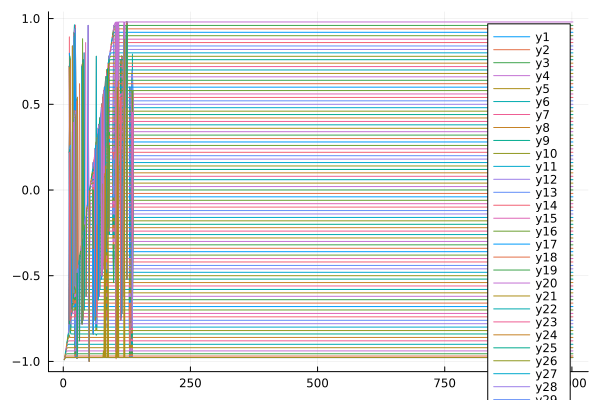

In [99]:
plot(ph1c')

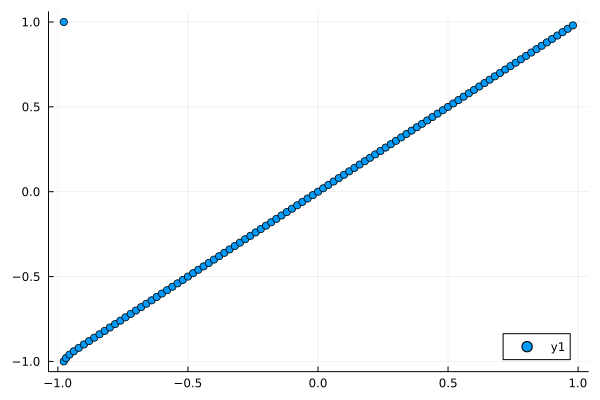

In [100]:
scatter(ph1c[:,end-1], phases)